In [53]:
import pandas as pd
import statistics 
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
test=pd.read_csv('	est_results.csv')
test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [15]:
user=pd.read_csv('/user_table.csv')
user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [19]:
#check the null value in test data
test.isnull().sum()

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

### Data cleaning 

In [21]:
#merge test and user tables 
df=test.merge(user,on='user_id',how='left')
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [24]:
df.groupby(['test','price'])['user_id'].count()

test  price
0     39       202517
      59          210
1     39          155
      59       113918
Name: user_id, dtype: int64

#### 
* There are 155 users who are supposed to be in the test group but are given a 39 item.
* There are 210 users who are supposed to be in the control group but are given a $59 item.


In [33]:
# remove probelmatic data
df.drop(df[(df['test']==0) & (df['price']==59)].index,inplace=True)
df.drop(df[(df['test']==1) & (df['price']==39)].index,inplace=True)
# df[(df['test']==0) & (df['price']==39) | (df['test']==1) & (df['price']==59)]

In [36]:
# create the revenue column
df['revenue']=df['price']*df['converted']

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
316795,17427,2015-04-11 09:29:15,ads_facebook,web,windows,0,39,0,NaN,NaN,NaN,NaN,0
316796,687787,2015-03-16 23:31:55,direct_traffic,web,windows,0,39,0,Bell Gardens,USA,33.97,-118.15,0
316797,618863,2015-04-11 01:35:19,ads-google,web,mac,0,39,0,West Seneca,USA,42.84,-78.75,0
316798,154636,2015-05-14 05:46:42,friend_referral,mobile,android,0,39,0,Walnut Creek,USA,37.90,-122.04,0


### Question 1 Should the company sell its software for 39 or 59?

In [37]:
#check conversion rate for test and control group 
df.groupby('test')['converted'].mean()

test
0    0.019900
1    0.015555
Name: converted, dtype: float64

In [38]:
#check revenue for test and control group
df.groupby('test')['revenue'].mean()

test
0    0.776083
1    0.917748
Name: revenue, dtype: float64

#### For the control group, they have a higher conversion rate with 1.99%. While considering the revenue metrics, the average revenue for test group is actually larger than the control group. 

In [42]:
# check if the variance is the same for both of groups 
control_val=statistics.variance(df[df['test']==0]['revenue'])
test_val=statistics.variance(df[df['test']==1]['revenue'])
print(control_val)
print(test_val)

29.665078490573645
53.305330173629486


#### Since there are unequal variances for test and control groups, let's perform one-tailed welch's t test
* Null hypothesis H0: test group's average revenue is equal to or less than control group's average revenue
* Alternative hypothesis H1: test group's average revenue is higher than control group's average revenue 

In [47]:
from scipy.stats import ttest_ind 
ttest_ind(df[df['test']==1]['revenue'],df[df['test']==0]['revenue'],axis=0,alternative='greater',equal_var=False)

Ttest_indResult(statistic=5.715224666463108, pvalue=5.486288656210391e-09)

Based on the p-value, we can reject the Null hypothesis. Therefore, test group’s average revenue is significantly higher than control group’s average revenue.

Since price isn’t the only difference between test/control groups, so we cannot contribute the increase in average revenue to price. We need to run the experiment again to make sure that the price is the only difference between test and control groups. 

### Question 2 - Analysis of user behaviors 

The goal is to understand the user characterstics that lead to a higher conversion rate for the control group.

#### 1. Source

In [59]:
df_source=df.groupby('source')['converted'].mean().reset_index().sort_values(by='converted')
df_source

,source,converted
0,ads-bing,0.012001
5,direct_traffic,0.012294
4,ads_other,0.014350
2,ads-yahoo,0.014793
9,seo-other,0.015686
11,seo_facebook,0.016051
10,seo-yahoo,0.016226
8,seo-google,0.016978
3,ads_facebook,0.021198
1,ads-google,0.021502


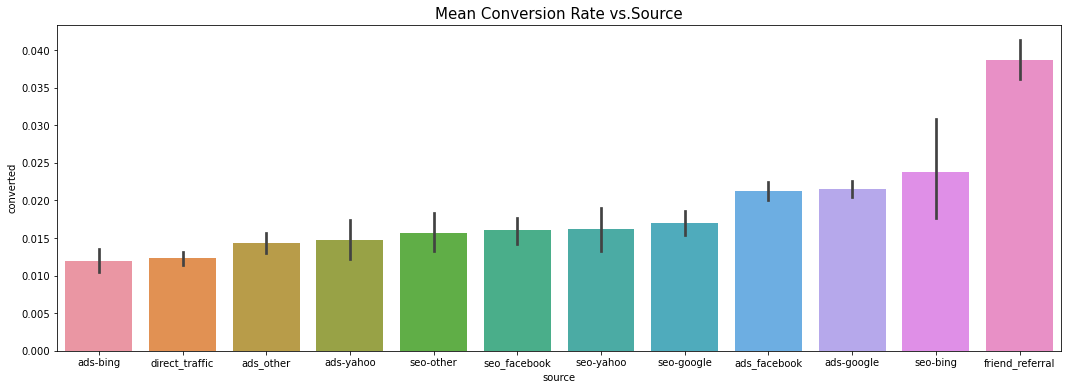

In [65]:
fig,ax=plt.subplots(figsize=(18,6))
sns.barplot(x='source',y='converted',data=df,ax=ax,order=df_source['source'])
ax.set_title('Mean Conversion Rate vs.Source',fontsize=15)
plt.show()

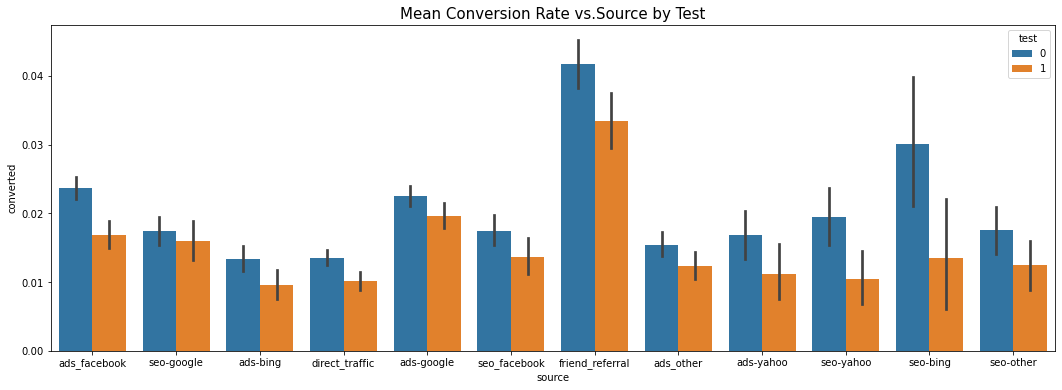

In [68]:
fig,ax=plt.subplots(figsize=(18,6))
sns.barplot(x='source',y='converted',hue='test',data=df,ax=ax)
ax.set_title('Mean Conversion Rate vs.Source by Test',fontsize=15)
plt.show()

#### 2. device

In [70]:
df.groupby('device')['converted'].mean().reset_index()

,device,converted
0,mobile,0.018554
1,web,0.018023


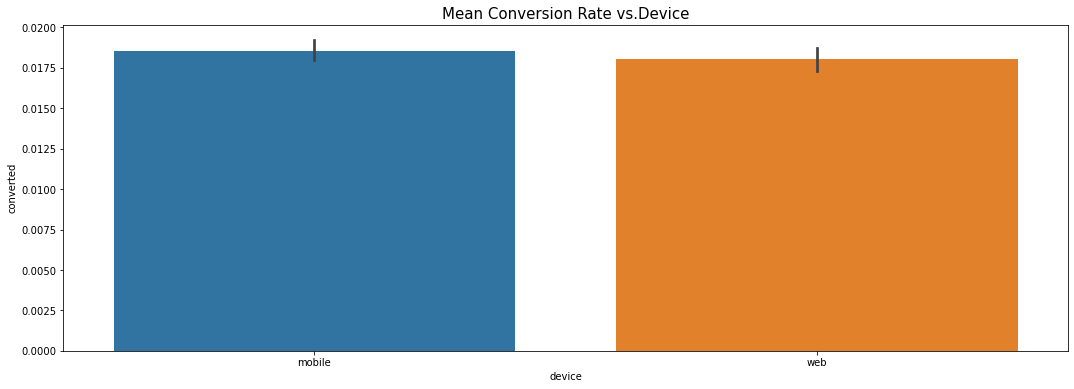

In [74]:
fig,ax=plt.subplots(figsize=(18,6))
sns.barplot(x='device',y='converted',data=df,ax=ax)
ax.set_title('Mean Conversion Rate vs.Device',fontsize=15)
plt.show()

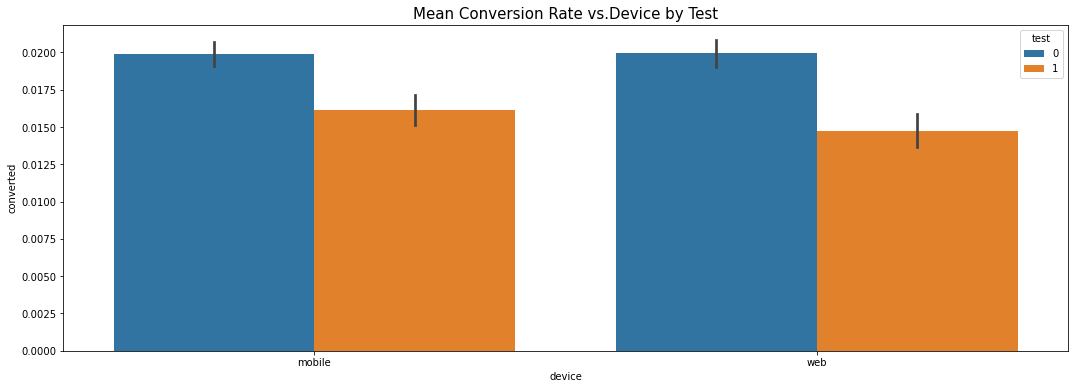

In [80]:
fig,ax=plt.subplots(figsize=(18,6))
sns.barplot(x='device',y='converted',hue='test',data=df,ax=ax)
ax.set_title('Mean Conversion Rate vs.Device by Test',fontsize=15)
plt.show()

#### 3. Operative systems

In [78]:
df.groupby('operative_system')['converted'].mean().reset_index().sort_values(by='converted')

,operative_system,converted
2,linux,0.008232
4,other,0.012981
0,android,0.014919
5,windows,0.016966
1,iOS,0.022328
3,mac,0.023987


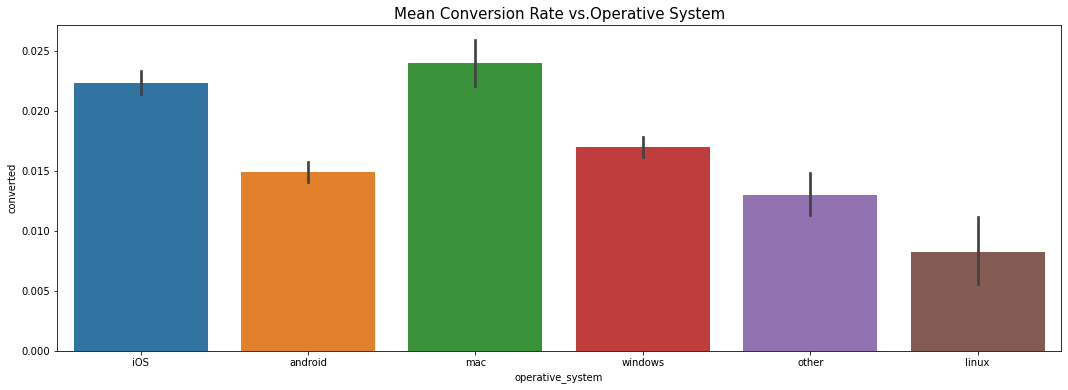

In [79]:
fig,ax=plt.subplots(figsize=(18,6))
sns.barplot(x='operative_system',y='converted',data=df,ax=ax)
ax.set_title('Mean Conversion Rate vs.Operative System',fontsize=15)
plt.show()

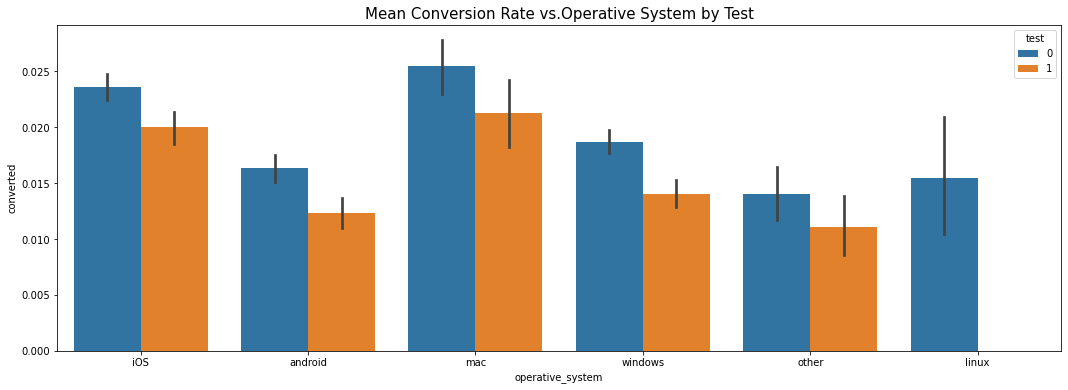

In [81]:
fig,ax=plt.subplots(figsize=(18,6))
sns.barplot(x='operative_system',y='converted',hue='test',data=df,ax=ax)
ax.set_title('Mean Conversion Rate vs.Operative System by Test',fontsize=15)
plt.show()

##### We can see that there are other features which influence the conversion rate in addition to price: 
    * Source: Friend-referral users have much higher conversion rate
    * Device: The influence is not significant 
    * Operative System: Mac and ios users have much higher conversion rate

##### Actionable insights

Since friend-referral, Mac or IOS have positive impact on the conversion rate, here's a couple of recommendations for the marketing campaign:

* Launch the special marketing campaign to target Mac and ios customers
* Offer the benefit(e.g. discount) to the customers if they refer our products to their friends. For the people who are referred by their friends can also get the benefit. 

### Question 3. How long should we run the test? 

In [87]:
print('start date of the experiment')
df['timestamp'].min()

start date of the experiment


'2015-03-02 00:04:12'

In [104]:
test_1=df[(df['test']==1) & (df['timestamp']<'2015-03-15')]['revenue'].values
control_1=df[(df['test']==0) & (df['timestamp']<'2015-03-15')]['revenue'].values
ttest_ind(test_1,control_1,axis=0,alternative='greater',equal_var=False)

Ttest_indResult(statistic=3.3242015742721187, pvalue=0.00044399362298297776)

Running the test for ~13 days results p value<0.001 thus it would be sufficient to get the significant difference between the average revenue of two groups. 